# Subgraph

In [5]:
import operator
from typing import Annotated, List, TypedDict

from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph

llm = ChatOllama(temperature=0, model='mistral:7b-instruct-v0.2-q6_K')

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're the jokester. Respond with a joke, the best joke ever fashioned.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ],
)


critic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You're the standup critic. Roast the bad joke."),
        MessagesPlaceholder(variable_name="messages"),
    ],
)


def update(out):
    return {"messages": [out]}


def replace_role(out):
    return {"messages": [("user", out.content)]}

Build the graph

In [6]:
## Build the subgraph


class SubGraphState(TypedDict):
    messages: Annotated[List, operator.add]


builder = StateGraph(SubGraphState)
builder.add_node("tell_joke", prompt | llm | update)
builder.add_node("critique", critic_prompt | llm | replace_role)


def route(state):
    return END if len(state["messages"]) >= 3 else "critique"


builder.add_conditional_edges("tell_joke", route)
builder.add_edge("critique", "tell_joke")
builder.set_entry_point("tell_joke")
joke_graph = builder.compile()

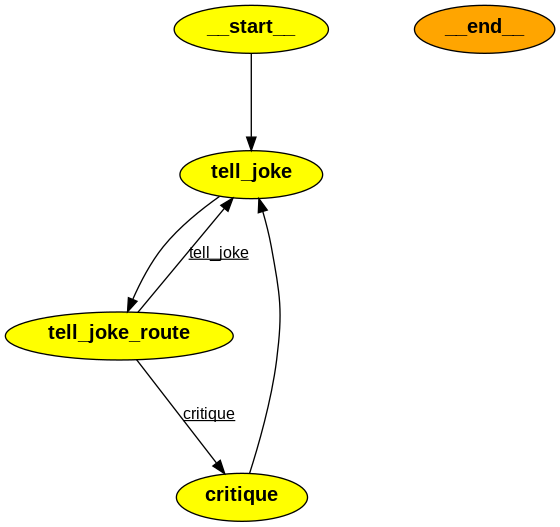

In [7]:
from IPython.display import Image

Image(joke_graph.get_graph().draw_png())

In [10]:
for step in joke_graph.stream({"messages": [("user", "Tell a joke about pizza")]}):
    print(step)

{'tell_joke': {'messages': [AIMessage(content=" Why don't some types of pizza get invited to parties?\n\nBecause they're too pie-shy! But if you give them a little confidence boost by topping them up with great company like pepperoni, mushrooms, or olives, they'll come out of their shell and be the life of the party!")]}}
{'critique': {'messages': [('user', "\n\nNow that's a joke even a bad comedian can deliver!")]}}
{'tell_joke': {'messages': [AIMessage(content=" I'm glad you found it amusing! Here's another one for those who love pizza and wordplay:\n\nWhy did the tomato turn red?\n\nBecause it saw the salad dressing! But in reality, it was because it became a sauce for pizza. Now that's a tomato-riffic twist on things!")]}}
{'__end__': {'messages': [('user', 'Tell a joke about pizza'), AIMessage(content=" Why don't some types of pizza get invited to parties?\n\nBecause they're too pie-shy! But if you give them a little confidence boost by topping them up with great company like pepp

##### Main Graph

Main graph acts as a router between joke graph or responds to the user

In [29]:
class AsssistantState(TypedDict):
    conversation: Annotated[List, operator.add]
    
assistant_llm = ChatOllama(model='mistral:7b-instruct-v0.2-q6_K')

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', "you are a helpful assistant"),
        MessagesPlaceholder(variable_name='conversation')
    ]
)

def add_to_conversation(message):
    return {'conversation': [message]}

main_builder = StateGraph(AsssistantState)
main_builder.add_node(
    'assistant', assistant_prompt | assistant_llm | add_to_conversation
)

def get_user_message(state: AsssistantState):
    last_message = state['conversation'][-1]
    
    #convert to sub-graph state
    return {'messages': [last_message]}

def get_joke(state: SubGraphState):
    final_joke = state["messages"][-1]
    return {"conversation": [final_joke]}


main_builder.add_node('joke_graph', get_user_message | joke_graph | get_joke)

def route(state: AsssistantState):
    if 'joke' in state['conversation'][-1][-1]:
        return 'joke_graph'
    return 'assistant'

main_builder.set_conditional_entry_point(
    route
)

main_builder.set_finish_point('assistant')
main_builder.set_finish_point('joke_graph')

graph = main_builder.compile()
    

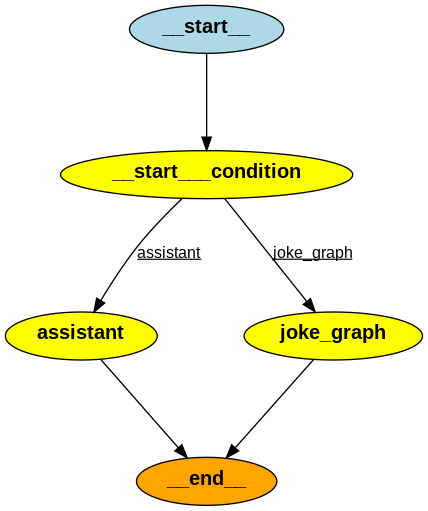

In [30]:
Image(graph.get_graph().draw_png())

In [31]:
for step in graph.stream({"conversation": [("user", "Tell a joke about pasta")]}):
    print(step)

{'joke_graph': {'conversation': [AIMessage(content=" Oh no, I'm here to bring the laughs! But I'll take your constructive criticism to heart and come back stronger with a fresh pasta joke. Here goes:\n\nWhy did the tomato turn red when it saw the pasta? Because it saw sauce-age! 🍅🍝 #TomatoSauce #PastaLaughs #RedHotJoke\n\nI hope that one brings a smile to your face! Let me know if you have any other requests or topics for jokes. 😊 #JokeTime #SpreadTheLaughter")]}}
{'__end__': {'conversation': [('user', 'Tell a joke about pasta'), AIMessage(content=" Oh no, I'm here to bring the laughs! But I'll take your constructive criticism to heart and come back stronger with a fresh pasta joke. Here goes:\n\nWhy did the tomato turn red when it saw the pasta? Because it saw sauce-age! 🍅🍝 #TomatoSauce #PastaLaughs #RedHotJoke\n\nI hope that one brings a smile to your face! Let me know if you have any other requests or topics for jokes. 😊 #JokeTime #SpreadTheLaughter")]}}


In [33]:
for step in graph.stream({"conversation": [("user", "How YOU doin?")]}):
    print(step)

{'assistant': {'conversation': [AIMessage(content=" I'm just an artificial intelligence, I don't have the ability to feel or have emotions. But I'm here and ready to help answer any question or assist with any task you might have! How can I help you today?")]}}
{'__end__': {'conversation': [('user', 'How YOU doin?'), AIMessage(content=" I'm just an artificial intelligence, I don't have the ability to feel or have emotions. But I'm here and ready to help answer any question or assist with any task you might have! How can I help you today?")]}}
